# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `28`
* Students: `Guillain, Léonore Valentine; Pase, Francesco; Rusu, Cosmin-Ionut; Zhuang, Ying`
* Dataset: `Flight Routes`


## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

#only used as helper functions for plotting and loading the lables
import pandas as pd
import networkx as nx

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
adjacency = np.load('adjacency.npy') # the adjacency matrix

We take the time zones as lables as label:

In [4]:
features = pd.read_csv("features.csv", index_col=0)

Here we calculate the values needed in this homework: **graph, laplacian, the eigenvalues**

In [5]:
graph = nx.from_numpy_array(adjacency)
largest_cc = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_cc)
n_nodes =  len(largest_cc) # the number of nodes in the network

In [6]:
laplacian_graph = nx.laplacian_matrix(graph)
laplacian = laplacian_graph.todense()

In [7]:
eigenval, eigenvec = np.linalg.eigh(laplacian)

eigenvalues are already sorted! proof:

In [8]:
(~(sorted(eigenval) == eigenval)).sum()

0

Getting the **labels** that we will use in the homework, we will use the **timezone**:

In [9]:
labels = np.array(features.iloc[list(largest_cc)].Timezone.tolist())

getting the **gradient**:

In [10]:
adjacency_ = nx.adjacency_matrix(graph).todense()
n_edges = np.sum(np.where(adjacency_ > 0, 1, 0))

S = np.zeros((n_edges, n_nodes ))
c = 0
for x in range(n_nodes):
    for y in range (x, n_nodes):
        if(adjacency_[x,y] > 0):
            S[c, x] = np.sqrt(adjacency_[x,y])
            S[c, y] = -np.sqrt(adjacency_[x,y])
            c = c+1

In [11]:
D = sparse.csc_matrix(S)

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [12]:
#eigenval eigenvec are already ordered
e = eigenval # Ordered Laplacian eigenvalues.
U = eigenvec # Ordered graph Fourier basis.

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

**answer**

We plot it as a signal, encoding the value as color, and embedding the graph with geographical coordiantes.

In [13]:
#get geographical embedding of our graph:
pos = features.iloc[list(largest_cc)].apply(lambda x :[x.Longitude, x.Latitude], axis=1).to_dict()

In [14]:
def draw_map(node_color, cmap=plt.cm.Accent, width=0.01, create_fig=True, **kwargs):
    """Draws our graph in geographical embedding with for a given coloring"""
    if create_fig:
        fig = plt.figure(figsize=(10 , 5))
    
    nx.draw(graph, pos=pos, node_size=[10, 10], node_color=node_color, width = width, 
        cmap=cmap, **kwargs)

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


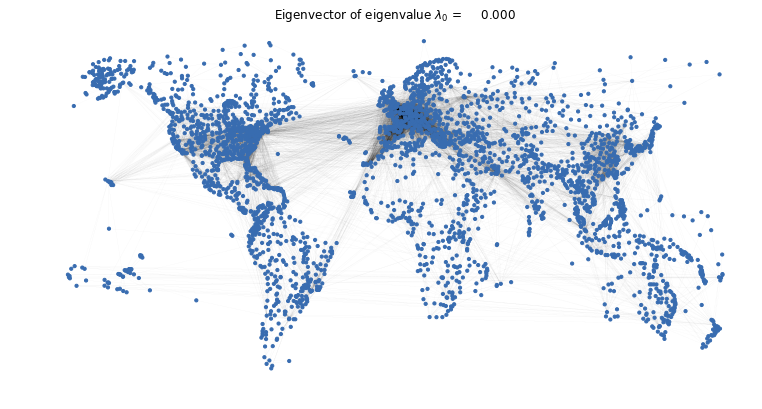

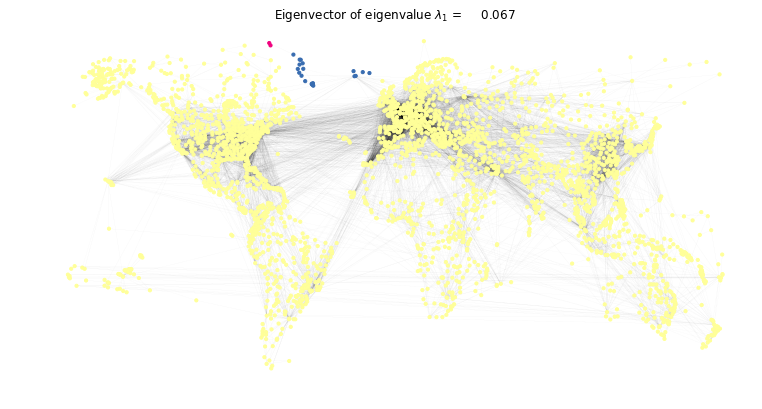

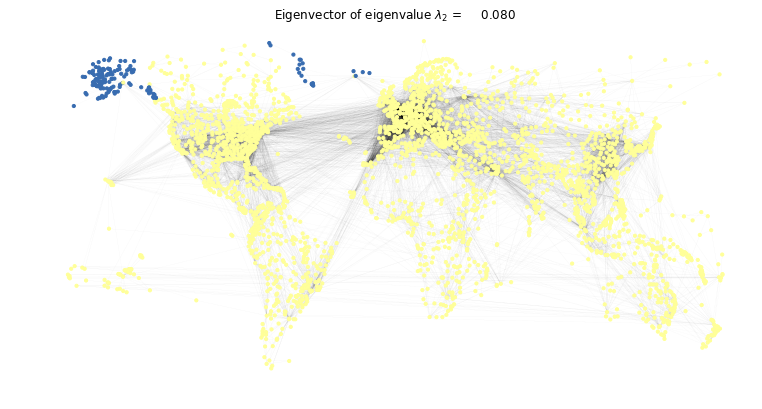

In [15]:
# Your code here.
relevant_vectors = list(range(3))
for i in relevant_vectors:
    
    f = np.array(np.squeeze(U[:, i]))[0]
    draw_map(list(f), vmin=-1, vmax=1)
    plt.title(f'Eigenvector of eigenvalue $\lambda_{i}$ = {e[i]:9.3f}')

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


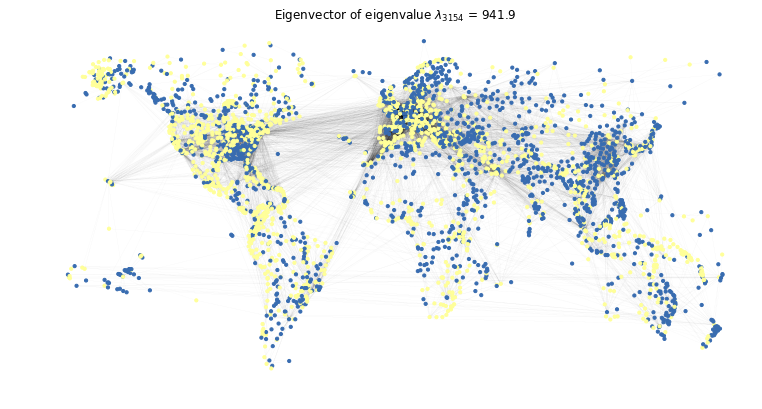

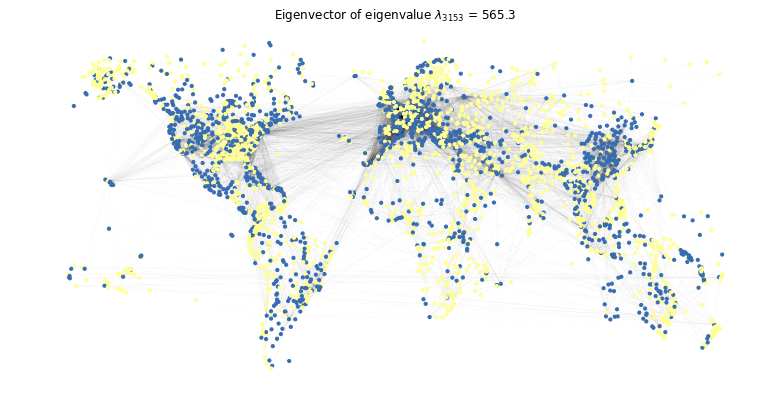

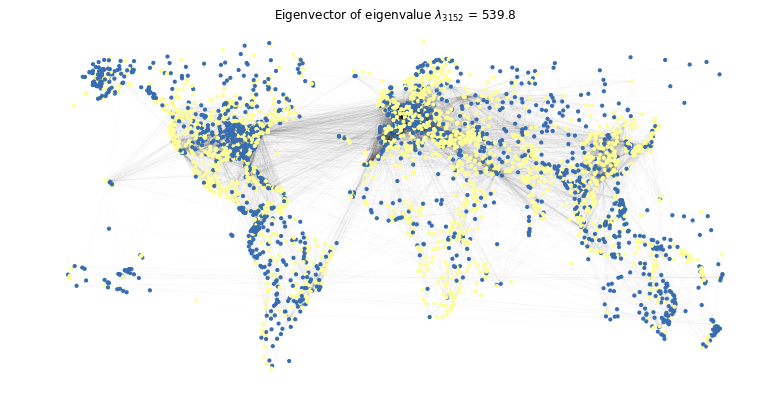

In [16]:
relevant_vectors = list(range(3))

for i in relevant_vectors:
    f = np.array(np.squeeze(U[:, -(i+1)]))[0]
    draw_map(f, vmin=-1, vmax=1)
    plt.title('Eigenvector of eigenvalue $\lambda_{'+str(n_nodes-i)+ '}$ = '+str(e[-(i+1)])[:5])

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**Your answer here.**

#TOCHECK

By looking at the plots above we see that the first eigenvectors have rather uniform values over the network, whereas the last eigenvectors present fast varying signal over the entire graph. 

Such beahviour rooted in the problem those vectors solve. We know that the eigenvector associated to the smallest eigenvalue ($\lambda_0 = 0$) is the constant one, and it is indeed the signal that minimizes the value : $ f^{\top} \mathbf{L} f = \sum_{i\sim j} \mathbf{W}(i,k)(f[i] - f]j])^2$, which contains the information on the smoothness of a signal $f$. 

In general, the i-th eigenvector minimizes this quadratic form $ f^{\top} \mathbf{L}f$ (Dirichlet form) with the additional constraint of being orthogonal (or even orthonormal) to the first $(i-1)$ eigenvectors. 

Indeed we can infer that higher eigenvectors (those related to higher eigenvalues) will vary faster and faster presenting in the graph domain (that is a general non-Euclidian domain) behaviours closely related to those of higer frequencies in the Real domain (with the Euclidean norm).

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [17]:
def GFT(x):
    return U.T @ x

def iGFT(x):
    return U @ x

### Question 4

Plot your feature/label vector as a signal on your graph

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


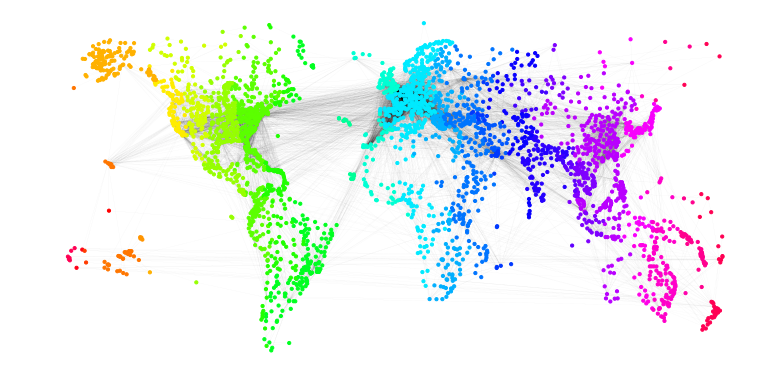

In [18]:
draw_map(labels, plt.cm.hsv)

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

<Figure size 1440x576 with 0 Axes>

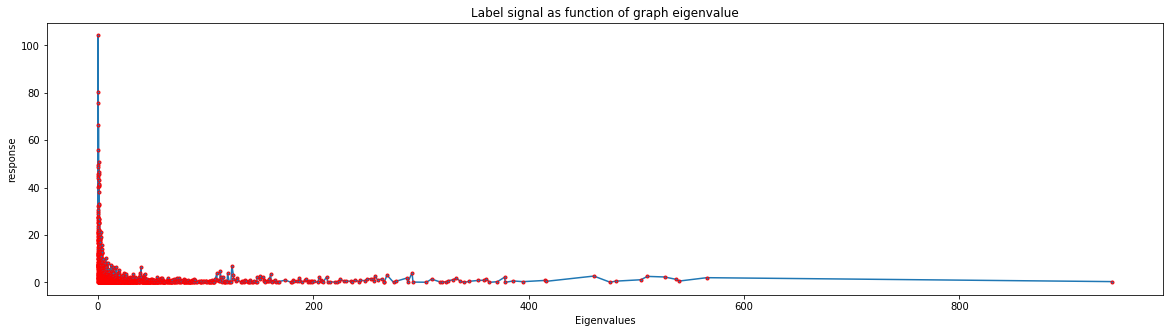

In [19]:
# Plot our features as eigenvalues functions
fig = plt.figure(figsize=(20 , 8))

#get label to correct dimension
label_vector = np.expand_dims(labels, 1)

plt.figure(figsize=(20, 5))
plt.title('Label signal as function of graph eigenvalue')
#we just want the absolute values
plt.plot(eigenval, abs(GFT(label_vector)), marker='.', markeredgecolor='red')
plt.xlabel('Eigenvalues')

_ = plt.ylabel('response')

We will also plot the logplot to see more about the dense cluster in the first one hundred eigenvalues.

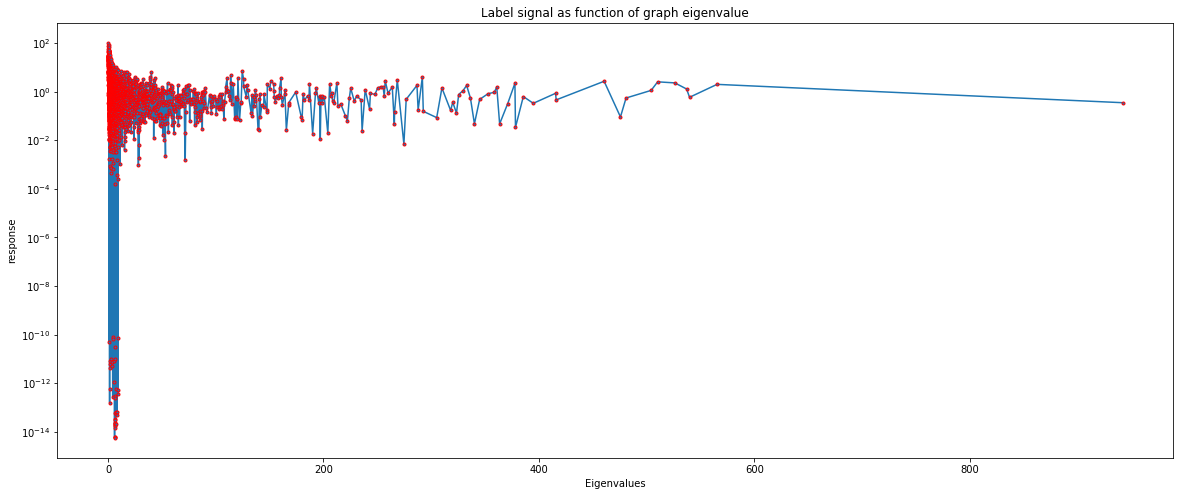

In [20]:
# Plot our features as eigenvalues functions
fig = plt.figure(figsize=(20 , 8))

#get label to correct dimension
label_vector = np.expand_dims(labels, 1)

plt.title('Label signal as function of graph eigenvalue')
#we just want the absolute values
plt.plot(eigenval, abs(GFT(label_vector)), marker='.', markeredgecolor='red')
plt.xlabel('Eigenvalues')
plt.yscale('log')

_ = plt.ylabel('response')

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Your answer here.**


#TODO: check

By costruction our signal is uniform among nodes belonging to similar geographical poistions (timezone, hence longitude) and varies among nodes that are more distant from each others. 

Such beahviour is also *partially* encoded in the first eigenvectors plotted in Q1: the reason is that even if there are flight routes between airports that could be far one from each other, the network structure is such for **isolated segments (Alaska/Greenland)** nodes belonging to close by geographic locations are more connected. 

Given that, signals related to the first eigenvectors has to be uniform in local areas and are allowed to vary just on distant nodes, encoding in this way smooth signals over the graph (as explained in Q2). 

We can also observe the same thing in the spectral (eigenvalues) domain: the "energy" of the GFT of our signal is mostly  distributed in the low eigenvalues, indicating that our signal is almost entirely composed by a linear combination the first eigenvectors.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [21]:
def heat_kernel(e, t):  
    #normalize for better results
    return  np.exp((-t * e/e[-1]))

def inverse_kernel(e, t):
    #point to point inversion
    return 1/(1 + t*e)

def rectangle_kernel(e, l_min, l_max):
    return ((e >= l_min) & (e<= l_max))

def graph_filter(x, kernel, **kwargs):
    #compute filtered signal in spectral domain and then return to graph domain
    
    #reshape to gt correct dimensions
    gft = GFT(x)
    gft = np.array(np.squeeze(gft))[0]
    
    k = kernel(e, **kwargs)
    return iGFT(np.expand_dims(gft * k, 1))

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

In [22]:
def plot_filtered(filtered_signal, e, title, log = False):
    plt.figure(figsize=(10,5))
    plt.plot(e, GFT(filtered_signal))
    plt.xlabel("graph frequency")
    if log:
        plt.xscale('log')
    plt.ylabel("value")
    plt.title(title)
    plt.show()

**Explination**
As mentioned before, the first eigenvectors contain the most information, hence we preform low pass flitering and adapt the filters to cut off the first values.

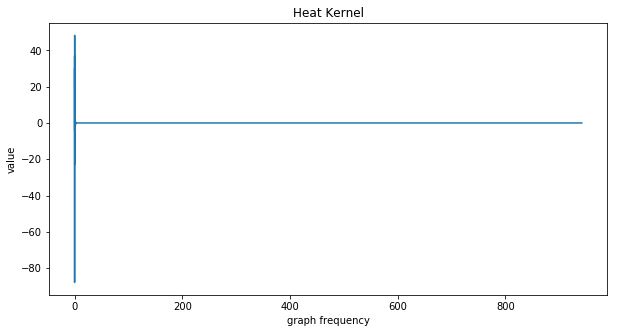

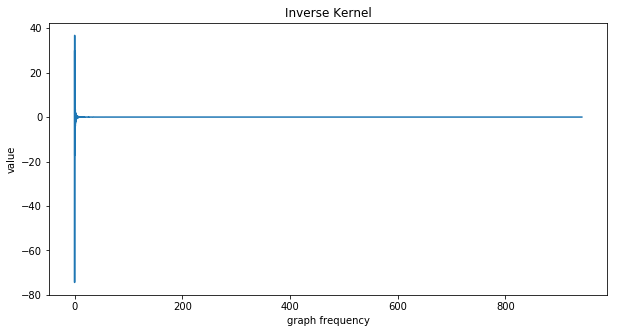

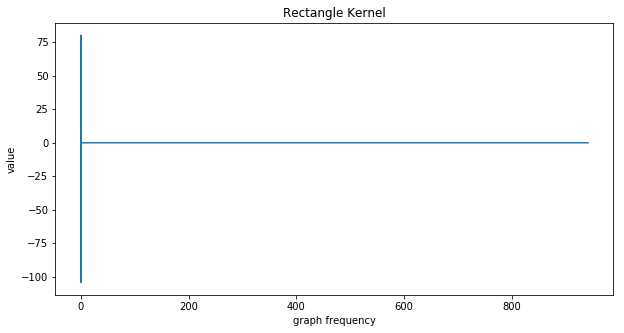

In [23]:
# Your code here.

filtered_signal = graph_filter(label_vector, heat_kernel, t=2000)
plot_filtered(filtered_signal, e, 'Heat Kernel')

filtered_signal = graph_filter(label_vector, inverse_kernel, t=5)
plot_filtered(filtered_signal, e, 'Inverse Kernel')

filtered_signal = graph_filter(label_vector, rectangle_kernel, l_min=0.01, l_max=0.6)
plot_filtered(filtered_signal, e, 'Rectangle Kernel')

Again, we will use a log scale for the xaxis to 'zoom' into the cluttered part.

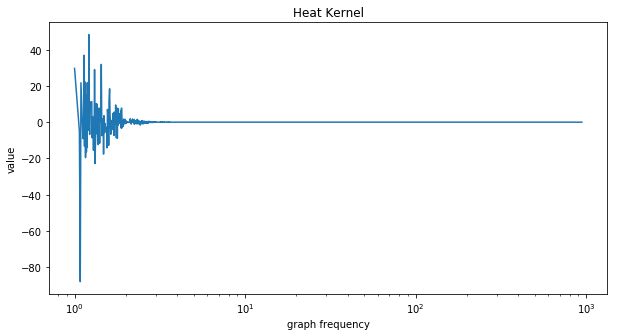

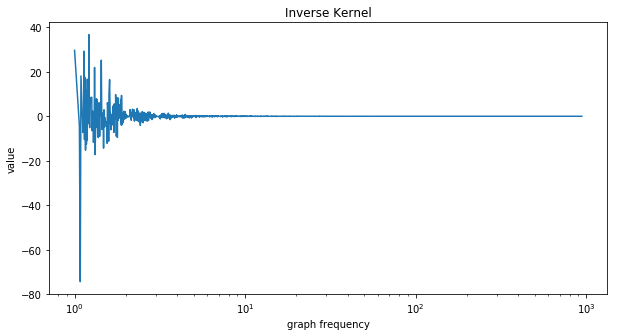

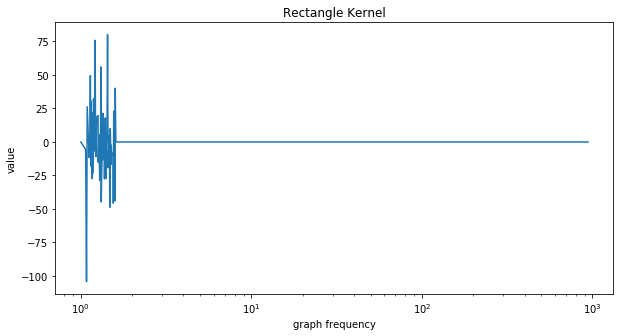

In [24]:
filtered_signal = graph_filter(label_vector, heat_kernel, t=2000)
plot_filtered(filtered_signal, e+1, 'Heat Kernel', log=True)

filtered_signal = graph_filter(label_vector, inverse_kernel, t=5)
plot_filtered(filtered_signal, e+1, 'Inverse Kernel', log=True)

filtered_signal = graph_filter(label_vector, rectangle_kernel, l_min=.01, l_max=0.6)
plot_filtered(filtered_signal, e+1, 'Rectangle Kernel', log=True)

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

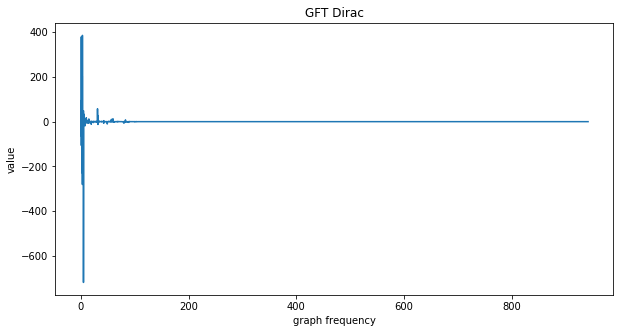

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


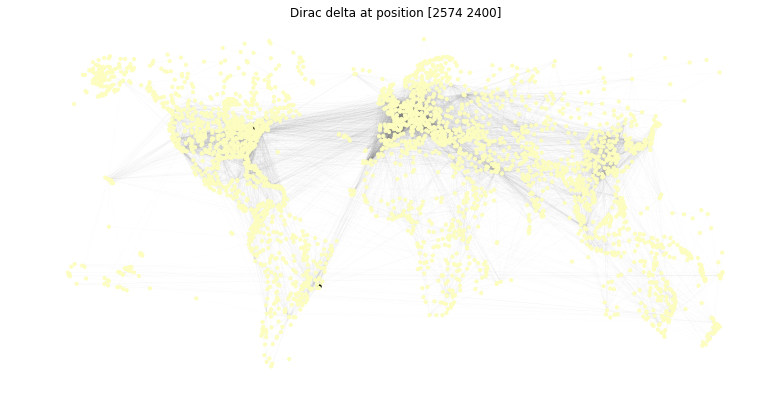

In [25]:
# Your code here.
f = np.zeros((n_nodes, 1))
peak_position = np.random.choice(graph.nodes,size=2)

f[peak_position] = 1000

plot_filtered(f, e, 'GFT Dirac')
draw_map(f.flatten(), plt.cm.magma_r, edge_color='grey')
plt.title('Dirac delta at position ' + str(peak_position))
plt.show()

In [26]:
def reshape(x):
    """Converts column vector in matrix format to array"""
    return np.array(np.squeeze(x))[0]

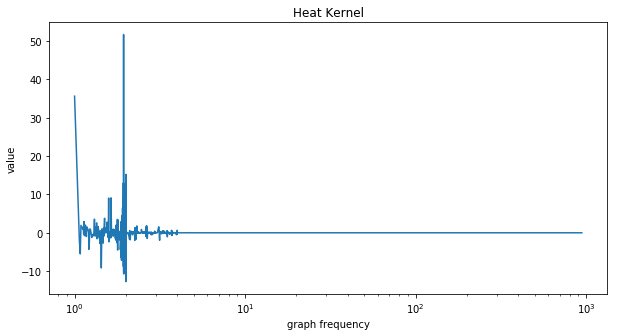

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


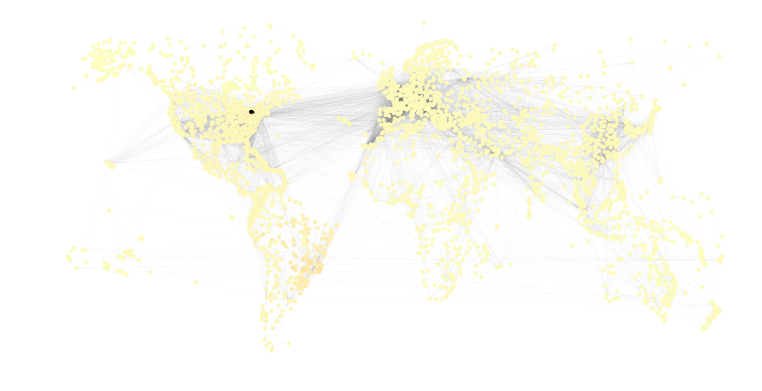

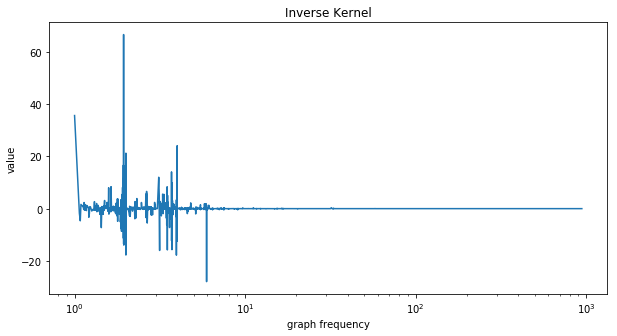

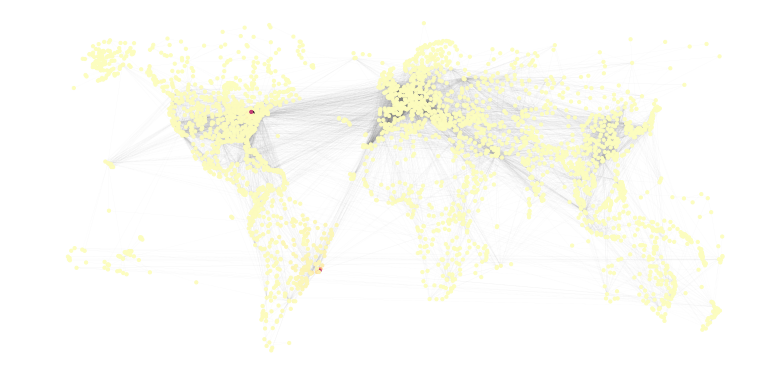

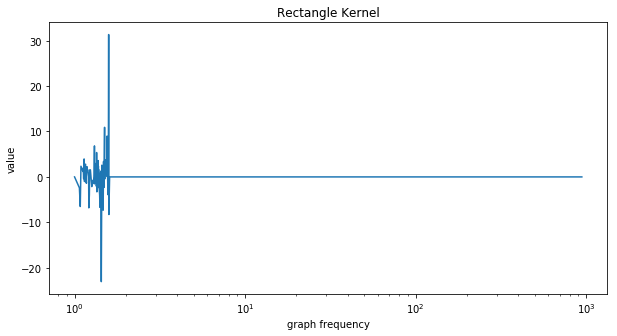

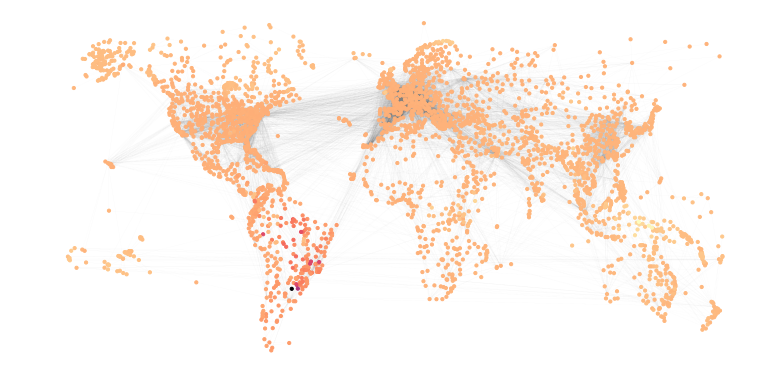

In [27]:
signal = graph_filter(f, heat_kernel, t=2000)
plot_filtered(signal, e+1, 'Heat Kernel', log=True)
draw_map(reshape(signal), plt.cm.magma_r, edge_color='grey')
plt.show()


signal = graph_filter(f, inverse_kernel, t=5)
plot_filtered(signal, e+1, 'Inverse Kernel', log=True)
draw_map(reshape(signal), plt.cm.magma_r, edge_color='grey')
plt.show()



signal = graph_filter(f, rectangle_kernel, l_min=.01, l_max=0.6)
plot_filtered(signal, e+1, 'Rectangle Kernel', log=True)
draw_map(reshape(signal), plt.cm.magma_r, edge_color='grey')
plt.show()


Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Your answer here.**

#TODO:check


The diffusion strongly depends on the initial location of the diracs. This is due to the star like structure of our graph. If the diract lies close to a hub or all on the hub, the signal will be distributed through out the graph, no matter the filter. However, if the dirac lies in a very isolated location, then the signal will barely defuse, due to the few connections. We now discuss the difference between the filters:

The heat kernel dissipates the energy through the network exactly as described above. We more of less see how well the other nodes in the graph are reachable from the nodes on which the dirac is placed.
The inverse kernel propagates the energy less than the heat kernel. This is because by design, the inverse kernel impements noise-reduction. Hence, the dirac is reduced, and dissipates only slightly around the location of the dirac. The dispersion happens as the inverse kernel is regular and thus implements this localisation.
For the rectangular kernel, we see a more even distribution and less dissipation than the inverse or heat kernel.
This is because the rectangular kernel is not regular. 

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [112]:
noise_variance = 24
noisy_measurements = labels + np.sqrt(noise_variance) * np.random.randn(n_nodes)

In [113]:
SNR = np.var(labels)/noise_variance
print(f'SNR: {SNR}')

SNR: 1.491803968965087


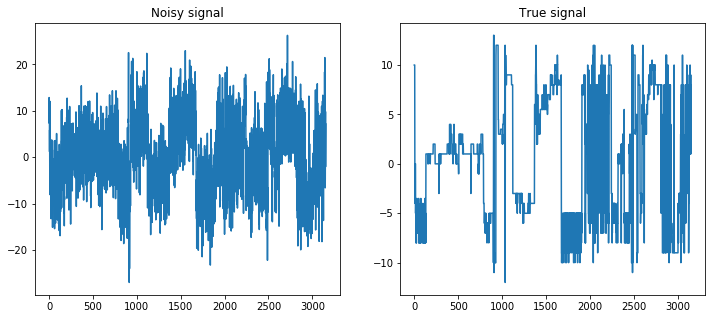

In [121]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('Noisy signal')
plt.plot(noisy_measurements)
plt.subplot(122)
plt.title('True signal')
plt.plot(labels)
plt.show()

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Your answer here.**

The function $: f = \|z-y\|_2^{2}+ \gamma z^\top L z$ is minimised at the point given by solving the equation

$$\frac{\partial f}{\partial z} = 0$$

Since

$$ \frac{\partial f}{\partial z} = 2(z-y)^\top + 2\gamma z^\top L $$ we can also rewrite as:

$$ (2(z-y)^\top + 2\gamma z^\top L)^\top = 2z -2y + 2\gamma Lz $$ because of transposition rule and the simmetry of $L$. We get now that $z^*$ is the solution fo the following equation:

$$ z -y + \gamma Lz = 0 $$

$$ z = (I + \gamma L)^{-1} y $$

Now, given that $L$ is symmetric, as seen in class we can write the function $g(L) = (I + \gamma L)^{-1}$ as a function of the eigenvalues (Borel functional calculus for symmetric matrices) $g(L) = \sum_{l \in \mathcal(S)(L)} f(\lambda_l)\mathbf{u}_l \mathbf{u}_l^\top$. We obtain:

$$ z^* = (I + \gamma L)^{-1} y = \sum_{l \in \mathcal(S)(L)} f(\lambda_l) u_l u_l^\top y =  \sum_{l \in \mathcal(S)(L)} (\frac{1}{1 + \gamma \lambda_l}) \hat{y}(\lambda_l) u_l $$.

We can easily see that such filter is a low-pass filter and it is indeed the Inverse filter of Q6 with $t=\gamma$.


### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [115]:
s_heat_denoised = graph_filter(noisy_measurements, heat_kernel, t=200)
z_heat_denoised = GFT(s_heat_denoised)

s_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, t=1)
z_inv_denoised = GFT(s_heat_denoised)

s_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, l_min=0.01, l_max=0.9)
z_rect_denoised = GFT(s_heat_denoised)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [116]:
def rel_err(labels, z):
    return np.linalg.norm(labels-z, ord=2)/np.linalg.norm(labels, ord=2)

In [117]:
print(f'Relative error true labels, noisy mesurement : {rel_err(labels, noisy_measurements):0.5}')
print(f'Relative error true labels, heat kernel :{rel_err(labels, reshape(s_heat_denoised)):0.5}')
print(f'Relative error true labels, inverse kernel :{rel_err(labels, reshape(s_inv_denoised)):0.5}')
print(f'Relative error true labels, rectangle kernel :{rel_err(labels, reshape(s_rect_denoised)):0.5}')

Relative error true labels, noisy mesurement : 0.81735
Relative error true labels, heat kernel :0.4907
Relative error true labels, inverse kernel :0.51084
Relative error true labels, rectangle kernel :0.55051


/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


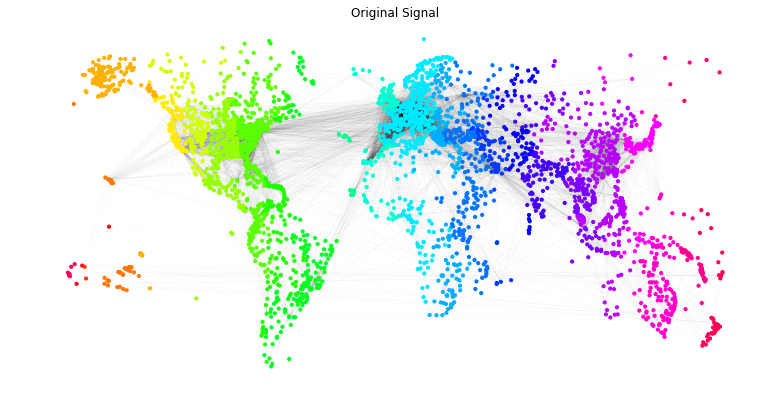

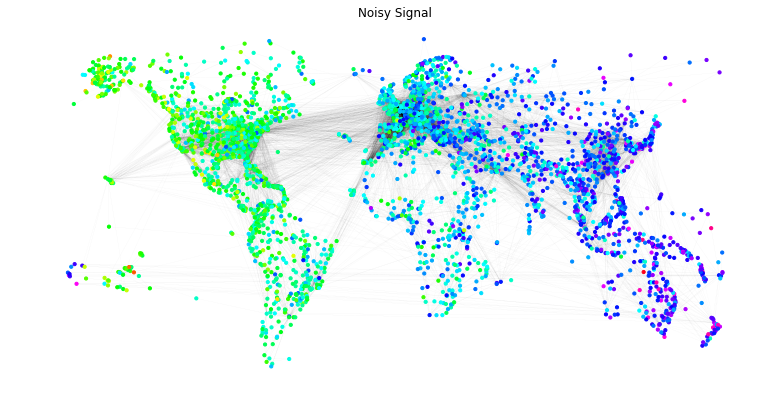

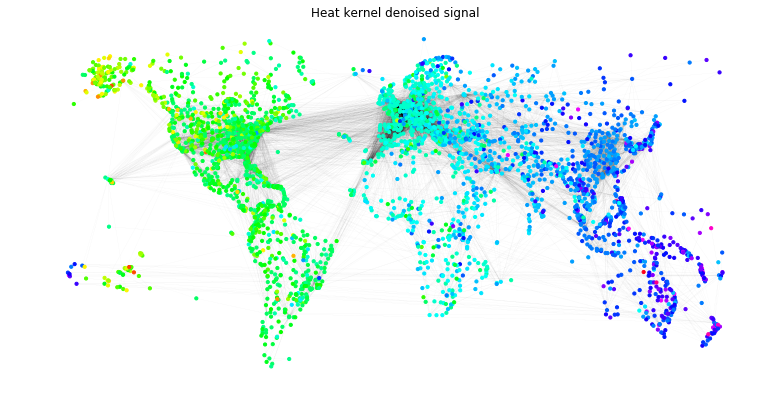

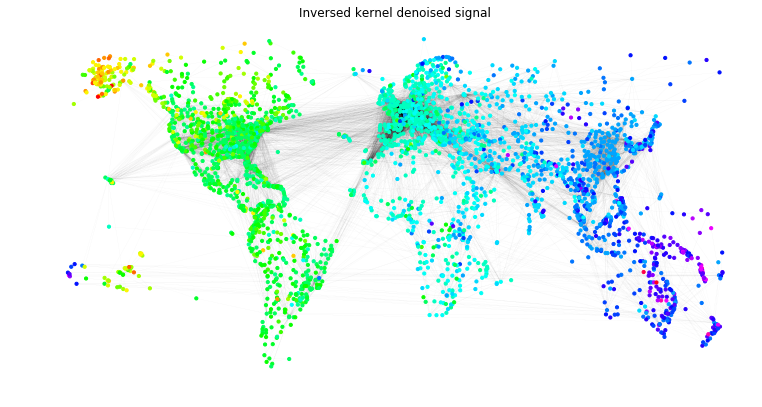

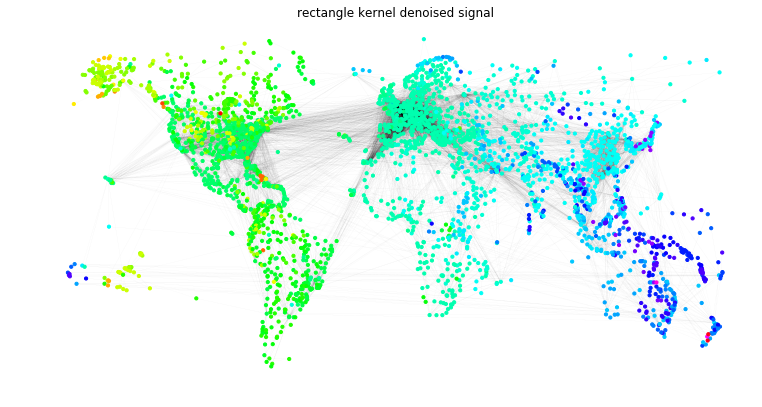

In [118]:
# Your code here.
relevant_vectors = [labels, noisy_measurements, s_heat_denoised, s_inv_denoised, s_rect_denoised]
titles = ['Original Signal', 'Noisy Signal', 'Heat kernel denoised signal', 'Inversed kernel denoised signal', 
          'rectangle kernel denoised signal']

for ind, signal in enumerate(relevant_vectors):
    if ind > 1:
        f = reshape(signal)
    else: 
        f = signal
    
    draw_map(np.ceil(f), plt.cm.hsv)
    plt.title(titles[ind])

Finally, overlay on the same plot the GFT of all five signals above.

Text(0.5, 1.0, 'Overlay of all signals')

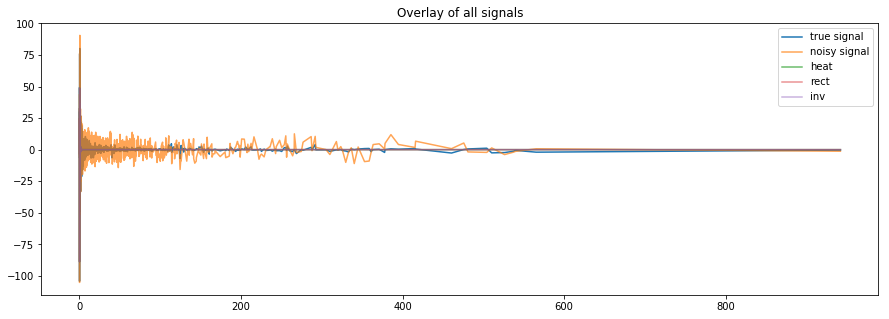

In [70]:
plt.figure(figsize=(15, 5))
plt.plot(eigenval, reshape(GFT(labels)))
plt.plot(eigenval, reshape(GFT(noisy_measurements)), alpha = 0.7)
plt.plot(eigenval, z_heat_denoised, alpha=0.7)
plt.plot(eigenval, z_rect_denoised, alpha=0.5)
plt.plot(eigenval, z_inv_denoised, alpha=0.5)
plt.legend(['true signal', 'noisy signal', 'heat', 'rect', 'inv'])
plt.title('Overlay of all signals')

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Your answer here.**
**TOCHECK**

The assumption we used to find the filtering values is that the low eigenvalue parts of the spectrum characterize our signal on graph well. This is the case as can be seen in Q4.

The rectangle signal preforms a projection on a subspace (this becomes cleare when we consider the effect of the filter on $\Lambda$.) So by applying the rectangle filter with the given parameters, we make the hypothesis that our true signal should mostly occus within the bounds of the rectangle, and that the noise occurs equally throught the frequency spectrum.

The inverse kernel, which by construction is used for denoising (Q10), makes the same assumtion but introduces a continous bound and we can see it works better than the rectangle and similar to the heat kernel. 

The heat kernel matches best due the to the exponential decrease shape our orignal signal has in the GFT domain.

Both the inverse and heat kernels assume that noise mostly affects higher frequency (increase with frequency). This is indeed what we have: the added gaussian noise varies randomly from point to point so by superposing it to our signal we stress higher eigenvectors to show up. 

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [36]:
def get_labels(x):
    if x < 1:
        return 1
    else:
        return -1
    
features.Timezone.map(get_labels).value_counts()

-1    1769
 1    1410
Name: Timezone, dtype: int64

In [37]:
labels_bin = np.array(features.iloc[list(largest_cc)].Timezone.map(get_labels).tolist())

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [38]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes) 

In [39]:
#choose 30 percent of labeles to keep
lables_to_keep = np.random.choice(np.arange(n_nodes), m, replace=False)
#set 0 and 1
alls_nodes = np.zeros(n_nodes, dtype=int)
alls_nodes[lables_to_keep]  = 1
print(f'Percentage of kept nodes : {alls_nodes.sum()/alls_nodes.shape[0]*100: 0.4}')

Percentage of kept nodes :  29.99


In [40]:
w = alls_nodes.copy() # Your code here.

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


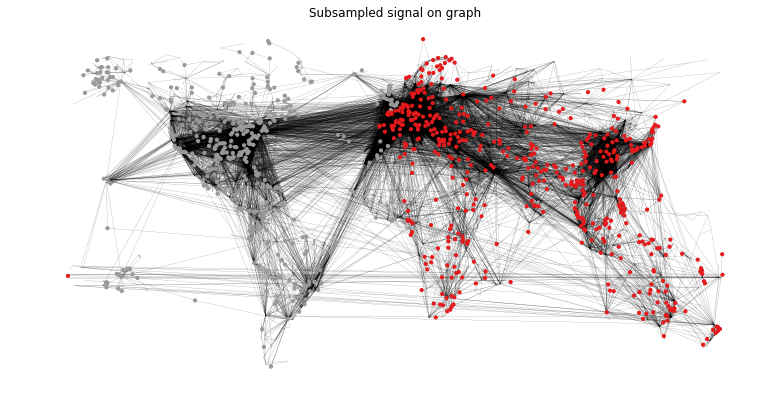

In [41]:
draw_map(labels_bin*np.where(w == 0, np.nan, 1), plt.cm.Set1, vmin=-1, vmax=1, width=0.1)
_ = plt.title('Subsampled signal on graph')

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

**from the function, make description more readable:

A signal $x$ is estimated from its measurements $y = A(x)$ by solving
    $`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` $

In [42]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [43]:
def P(a):
    # Your code here.
    b = a.copy()
    #set of known labels
    b[w==1] = labels_bin[w==1].copy()
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [44]:
#TODO: check what x0 is really supposed to be

x0 = np.random.rand(len(labels_bin))

sol_1norm_min = graph_pnorm_interpolation(D, P=P, p=1, x0=x0.copy())# Your code here.

sol_2norm_min = graph_pnorm_interpolation(D, P=P, p=2, x0=x0.copy())# Your code here.

threshold = 0

sol_1norm_bin = np.where(sol_1norm_min > threshold, 1, -1)# Your code here.
sol_2norm_bin = np.where(sol_2norm_min > threshold, 1, -1)# Your code here.

Solution found after 28 iterations:
    objective function f(sol) = 5.625122e+04
    stopping criterion: RTOL
Solution found after 147 iterations:
    objective function f(sol) = 1.993675e+04
    stopping criterion: RTOL


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


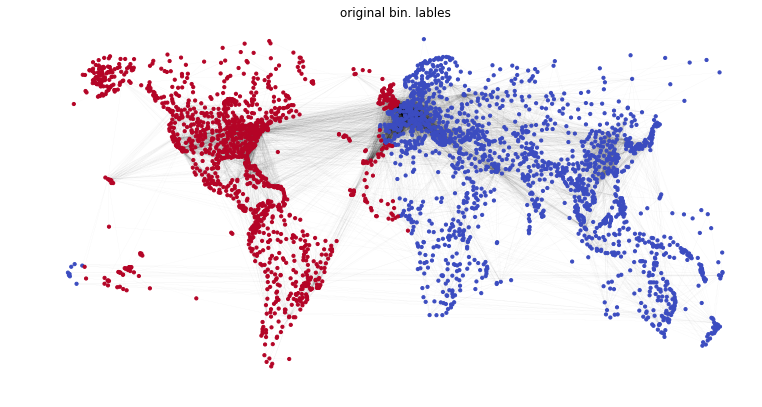

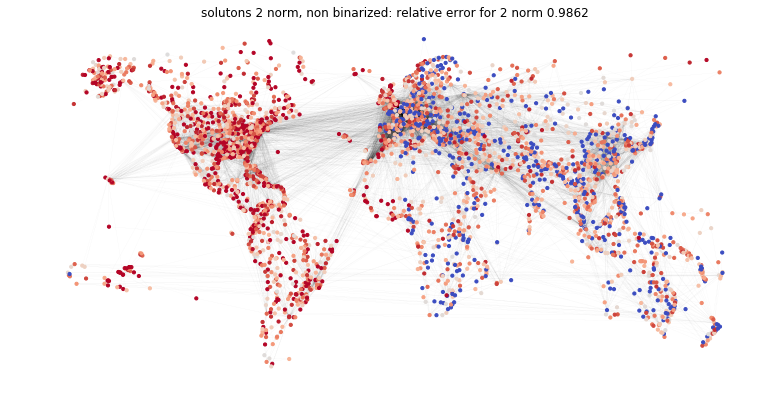

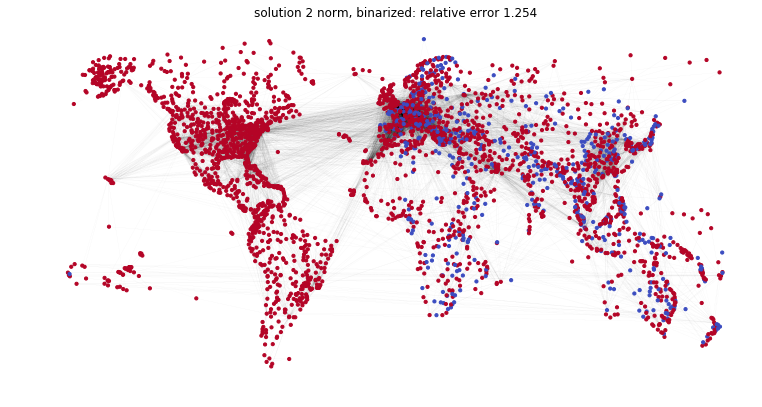

In [45]:
draw_map(labels_bin, plt.cm.coolwarm)
plt.title('original bin. lables')
draw_map(sol_2norm_min, plt.cm.coolwarm)
plt.title(f'solutons 2 norm, non binarized: relative error for 2 norm {rel_err(labels_bin, sol_2norm_min):0.4}')
draw_map(sol_2norm_bin, plt.cm.coolwarm)
_ = plt.title(f'solution 2 norm, binarized: relative error {rel_err(labels_bin, sol_2norm_bin):0.4}')

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


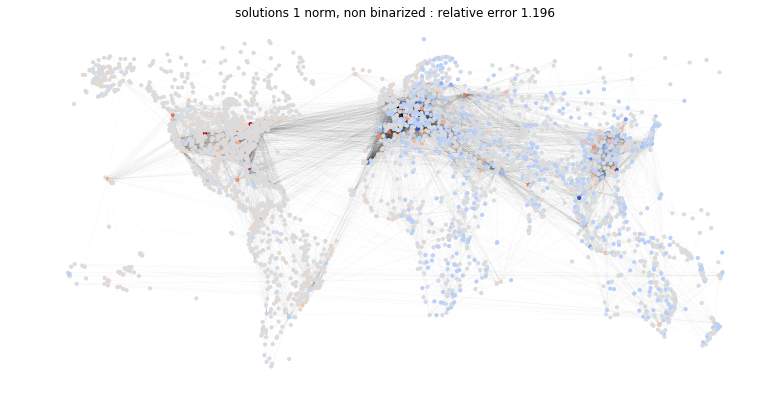

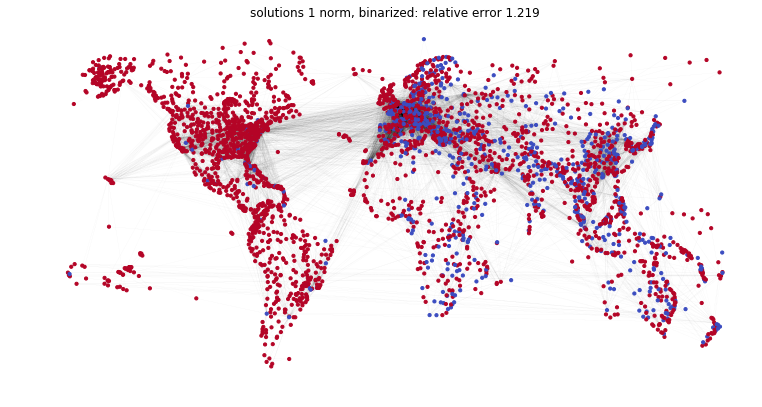

In [46]:
draw_map(sol_1norm_min, plt.cm.coolwarm)
plt.title(f'solutions 1 norm, non binarized : relative error {rel_err(labels_bin, sol_1norm_min):0.4}')

draw_map(sol_1norm_bin, plt.cm.coolwarm)
_ = plt.title(f'solutions 1 norm, binarized: relative error {rel_err(labels_bin, sol_1norm_bin):0.4}')

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [47]:
#redefine P for new w
def P(a, w):
    b = a.copy()
    #set of known labels
    b[w==1] = labels_bin[w==1].copy()
    return b


def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):

    # Create sample mask.
    
    # Solve p-norm interpolation.
    
    # Aggregate.
    pt_matrix=np.zeros((len(mn_ratios),len(thresholds)))
    #define starting point of iteration
    x0 = np.random.rand(len(labels_bin))
    for i,j in np.ndindex(pt_matrix.shape):
        m= int(mn_ratios[i]*n_nodes)
        for n in  range(n_trials):
            #defining the new w
            nodes_mat =np.zeros(n_nodes, dtype=int)
            nodes_mat[np.random.choice(np.arange(n_nodes), m, replace=False)]  = 1
            w = nodes_mat.copy()

            
            #getting the norm
            norm=graph_pnorm_interpolation(D, P=lambda x: P(x, w),p=p, x0=x0.copy(), verbosity='NONE')
            
            #binazizing the norm
            x0_bin=np.where(norm > thresholds[j], 1, -1)
            
            #calculating average rel_err & normalizing
            pt_matrix[i,j]+=rel_err(labels_bin,x0_bin)/n_trials 
            
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [48]:
mn_ratios = np.linspace(0.01, 0.9, 5) # Your code here.

thresholds = np.linspace(-.9, 0.9, 5) # Your code here.

n_trials=20

pt_matrix_1norm = phase_transition(mn_ratios,thresholds,n_trials,labels_bin,1)# Your code here.
pt_matrix_2norm = phase_transition(mn_ratios,thresholds,n_trials,labels_bin,2)# Your code here.

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

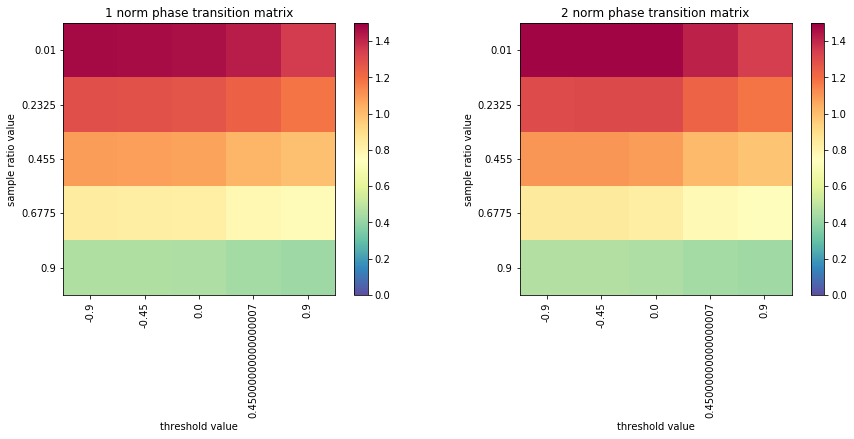

In [49]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('1 norm phase transition matrix')
plt.imshow(pt_matrix_1norm, vmin=0, vmax=1.5, cmap=plt.cm.Spectral_r)
plt.colorbar()
plt.yticks(list(range(len(mn_ratios))), mn_ratios)
plt.xticks(list(range(len(thresholds))), thresholds, rotation=90)

plt.ylabel('sample ratio value')
plt.xlabel('threshold value')

plt.subplot(122)
plt.title('2 norm phase transition matrix')
plt.imshow(pt_matrix_2norm, vmin=0, vmax=1.5, cmap=plt.cm.Spectral_r)
plt.colorbar()
plt.yticks(list(range(len(mn_ratios))), mn_ratios)
plt.xticks(list(range(len(thresholds))), thresholds, rotation=90)

plt.ylabel('sample ratio value')
plt.xlabel('threshold value')
plt.show()

In [50]:
#does the l1 norm outpreform the l2 norm?
pt_matrix_1norm < pt_matrix_2norm

array([[ True,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True, False,  True]])

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Your answer here.**

#TODO

From the two plots it is hard to see which one preforms better. However when wee look at the values and build the comparison matrix we can see that the 1norm outpreforms the 2norm in almost all cases. The 2norm outpreforms the 1norm for very large threhold values. This is likely due to the low values the 1norm produces.

The intuition of the 1norm outpreforming the n2 norm comes from geometry:

#insert explination


From the plot in Q17 we The l2norm performs better than the 1norm in the case where we do not binarize the signal. This is due to the low values produced by the l1norm. 

